In [103]:
#pip install tensorflow efficientnet
#!pip install seaborn


In [104]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, History, EarlyStopping
from efficientnet.tfkeras import EfficientNetB0
import psutil
from tensorflow.keras.regularizers import l1
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import seaborn as sns

In [105]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [106]:
datagen = ImageDataGenerator(
        rescale=1.0 / 255.0,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2]
    )

train_generator = datagen.flow_from_directory(
    '/mnt/d/My_projects/programs/Python projects/dbi-ai-model/res/dogImages/dogImages/train',
    #'D:\My projects\programs\Python projects\dbi-ai-model\\res\\archive_300x300_30class\dogImages\dogImages\\train',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical')

valid_generator = datagen.flow_from_directory(
    '/mnt/d/My_projects/programs/Python projects/dbi-ai-model/res/dogImages/dogImages/valid',
    #'D:\My projects\programs\Python projects\dbi-ai-model\\res\\archive_300x300_30class\dogImages\dogImages\\valid',
    target_size=(224, 224),
    batch_size=8,
    shuffle=False,
    class_mode='categorical')


Found 6679 images belonging to 133 classes.
Found 835 images belonging to 133 classes.


In [107]:
print(train_generator.class_indices)

{'001.Affenpinscher': 0, '002.Afghan_hound': 1, '003.Airedale_terrier': 2, '004.Akita': 3, '005.Alaskan_malamute': 4, '006.American_eskimo_dog': 5, '007.American_foxhound': 6, '008.American_staffordshire_terrier': 7, '009.American_water_spaniel': 8, '010.Anatolian_shepherd_dog': 9, '011.Australian_cattle_dog': 10, '012.Australian_shepherd': 11, '013.Australian_terrier': 12, '014.Basenji': 13, '015.Basset_hound': 14, '016.Beagle': 15, '017.Bearded_collie': 16, '018.Beauceron': 17, '019.Bedlington_terrier': 18, '020.Belgian_malinois': 19, '021.Belgian_sheepdog': 20, '022.Belgian_tervuren': 21, '023.Bernese_mountain_dog': 22, '024.Bichon_frise': 23, '025.Black_and_tan_coonhound': 24, '026.Black_russian_terrier': 25, '027.Bloodhound': 26, '028.Bluetick_coonhound': 27, '029.Border_collie': 28, '030.Border_terrier': 29, '031.Borzoi': 30, '032.Boston_terrier': 31, '033.Bouvier_des_flandres': 32, '034.Boxer': 33, '035.Boykin_spaniel': 34, '036.Briard': 35, '037.Brittany': 36, '038.Brussels_gri

In [108]:
def set_memory_limit():
    process = psutil.Process(os.getpid())
    mem_limit = 9e9  # 8 GB
    process.memory_info()._asdict()['rss'] = mem_limit

In [109]:

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) == 0:
    raise RuntimeError("Brak dostępnej karty graficznej. Upewnij się, że CUDA i cuDNN są zainstalowane.")

for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, True)
        
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(units=train_generator.num_classes, activation='softmax', kernel_regularizer=l1(1e-5))
    ])

model.summary()

optimizer = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functiona  (None, 7, 7, 1280)        4049564   
 l)                                                              
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 133)               170373    
                                                                 
Total params: 4219937 (16.10 MB)
Trainable params: 4177921 (15.94 MB)
Non-trainable params: 42016 (164.12 KB)
_________________________________________________________________


In [110]:
checkpoint = ModelCheckpoint('best_weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)

In [111]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [112]:
#model.load_weights("best_weights.h5")

In [113]:
model_result = model.fit(train_generator,
                         epochs=20,
                         validation_data=valid_generator,
                         #validation_data=(valid_input, valid_output)
                         callbacks=[checkpoint, early_stopping]
                         )

Epoch 1/20


2023-12-24 11:57:42.550913: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/efficientnet-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


835/835 [==============================] - ETA: 0s - loss: 4.0953 - accuracy: 0.1458
Epoch 1: val_loss improved from inf to 2.24730, saving model to best_weights.h5
835/835 [==============================] - 210s 219ms/step - loss: 4.0953 - accuracy: 0.1458 - val_loss: 2.2473 - val_accuracy: 0.5066
Epoch 2/20
835/835 [==============================] - ETA: 0s - loss: 2.2925 - accuracy: 0.4471
Epoch 2: val_loss improved from 2.24730 to 1.22713, saving model to best_weights.h5
835/835 [==============================] - 138s 166ms/step - loss: 2.2925 - accuracy: 0.4471 - val_loss: 1.2271 - val_accuracy: 0.6778
Epoch 3/20
835/835 [==============================] - ETA: 0s - loss: 1.6011 - accuracy: 0.5929
Epoch 3: val_loss improved from 1.22713 to 0.90793, saving model to best_weights.h5
835/835 [==============================] - 140s 168ms/step - loss: 1.6011 - accuracy: 0.5929 - val_loss: 0.9079 - val_accuracy: 0.7473
Epoch 4/20
835/835 [==============================] - ETA: 0s - loss: 

In [ ]:
model.save('best_model')

In [114]:
model.evaluate(train_generator)

835/835 [==============================] - 108s 129ms/step - loss: 0.1772 - accuracy: 0.9680


[0.17724017798900604, 0.9679592847824097]

In [115]:
model.evaluate(valid_generator)

105/105 [==============================] - 14s 128ms/step - loss: 0.6803 - accuracy: 0.8108


[0.6803109645843506, 0.8107784390449524]

In [116]:

test_generator = datagen.flow_from_directory(
    #'D:\My projects\programs\Python projects\dbi-ai-model\\res\merged\\30_class_dataset\\test',
    '/mnt/d/My_projects/programs/Python projects/dbi-ai-model/res/dogImages/dogImages/test',
    target_size=(300, 300),
    batch_size=8,
    shuffle=False,
    class_mode='categorical')

model.evaluate(test_generator)

Found 836 images belonging to 133 classes.
105/105 [==============================] - 25s 240ms/step - loss: 0.6809 - accuracy: 0.8170


[0.6809118986129761, 0.8169856667518616]

In [117]:


# Get predictions from the model
predictions = model.predict(test_generator)
curr_gen = test_generator



105/105 [==============================] - 21s 188ms/step


In [118]:

predictions = model.predict(valid_generator)
curr_gen = valid_generator

105/105 [==============================] - 14s 130ms/step


[  0   0   0   0   0   0   0   0   1   1   1   1   1   1   1   2  86   2
   2  96   2  96   3   3   3   3   3   3   3   3   4   4   4   4   4   4
   4   4   4   5   5   5   5   5   5   5   5  15   6   9   6   6  36  43
   7   7   7   7   7  79   7   8   8   8   8   9   9   9   9   9   9  10
  10  10  10  10  10  10  10  11  11  11  11  11  11  11  11  12  86  12
  12  12   2  13  13  13  13  13  13  13  13 129  61  14  14  26  14  14
  14  14  15  15  15  15  15  15  15  16  16  16  16  16  16  16  17  17
  17  58  92  58  18  18  18  18  18  18  10  19  19  19  46  19  19  19
  20  20  20  20  20  91  20  20  21  21  21  21  21  21  22  22  22  22
  22  22  22  22  23 112  23  23  23  23  23  24  24  24  27  24  25  25
  25  25  25  26  26  26  26  26  26  26  26  27  27  27  24  27  28  28
  28  28  28  28  28  28  28  29  29  29  29  88  29  30  30  30  30  30
  30  30  31  31  31  31  31  31  31  31  32  32  25 124  25  32  33  39
  40  33  33  33   7  33  34  34  34  34  34  34  3

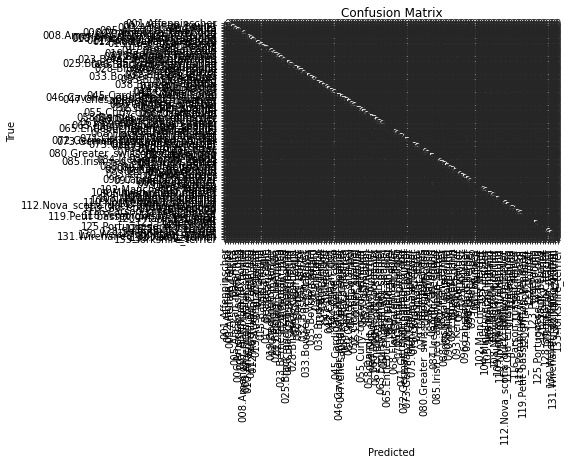

In [119]:
c = np.argmax(predictions, axis=1)
print(c)


conf_matrix = confusion_matrix(curr_gen.classes, c)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

true_labels = curr_gen.labels

cr = classification_report(true_labels, c, output_dict=True)

# You can also print a classification report
# print("\nClassification Report:")
# print(classification_report(true_labels, c))

class_names = list(curr_gen.class_indices.keys())

df = pd.DataFrame({
    'Label': [class_names[i] for i in range(curr_gen.num_classes)],
    'Precision': [cr[str(i)]['precision'] for i in range(curr_gen.num_classes)],
})

df.to_csv('classification_metrics_133class.csv', index=False)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=curr_gen.class_indices.keys(),
            yticklabels=curr_gen.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

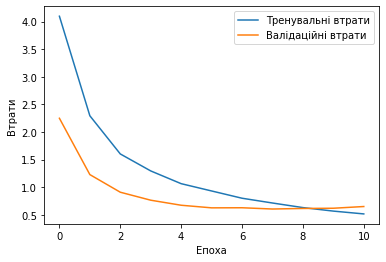

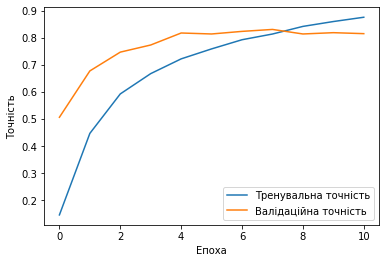

In [120]:
plt.plot(model_result.history['loss'], label='Тренувальні втрати')
plt.plot(model_result.history['val_loss'], label='Валідаційні втрати')
plt.xlabel('Епоха')
plt.ylabel('Втрати')
plt.legend()
plt.show()

plt.plot(model_result.history['accuracy'], label='Тренувальна точність')
plt.plot(model_result.history['val_accuracy'], label='Валідаційна точність')
plt.xlabel('Епоха')
plt.ylabel('Точність')
plt.legend()
plt.show()